# Setup
### Import libraries

In [1]:
import nltk
from nltk import pos_tag
import string
import pandas as pd
from collections import defaultdict
from scipy.stats import zscore
import scipy.stats as stats
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
import numpy as np
from collections import defaultdict
import re
from textblob import TextBlob
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.stats import pearsonr, spearmanr
from nltk.corpus import verbnet as vn
from nltk.corpus.reader.verbnet import VerbnetCorpusReader
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from datasets import load_dataset
import spacy
vn_reader = VerbnetCorpusReader(root=nltk.data.find('corpora/verbnet').path, fileids='.*\.xml')

/Users/souparna/Desktop/DiyaDiss/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Ensure necessary downloads
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/souparna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/souparna/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/souparna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/souparna/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/souparna/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Load and clean dataset

In [3]:
ds = load_dataset("ucberkeley-dlab/measuring-hate-speech", split="train")

In [4]:
# chooses text from Platform 0, then retains only text and HS score columns
filtered_ds = ds.filter(lambda x: x['platform'] == 0).select_columns(['text','hate_speech_score']) # Change HERE FOR YT REDDIT AND X TODO

# converts data structure to Pandas DataFrame
filtered_df = pd.DataFrame(filtered_ds)

In [5]:
# Arabic Unicode range (General Arabic script: 0600–06FF, Arabic Supplement: 0750–077F, etc.)
arabic_re = re.compile(r"[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF]")

# Function to check if text contains Arabic script
filtered_df = filtered_df[~filtered_df["text"].str.contains(arabic_re, na=False)]

In [6]:
# collapse all entries with the same text into a single entry with a single hate_speech_score
# the hate_speech_score in the dataset considers annotator labels as well as a weighting factor (annotator bias/severity)
filtered_df = filtered_df.groupby('text', as_index=False).median('hate_speech_score')

questions that require more contextual understanding (not just counting verbs); what are the socially interesting questions? social-psychological background to all of this in write-up.

# Text processing

In [7]:
tokenised_df = filtered_df.copy()
# print(tokenised_df)

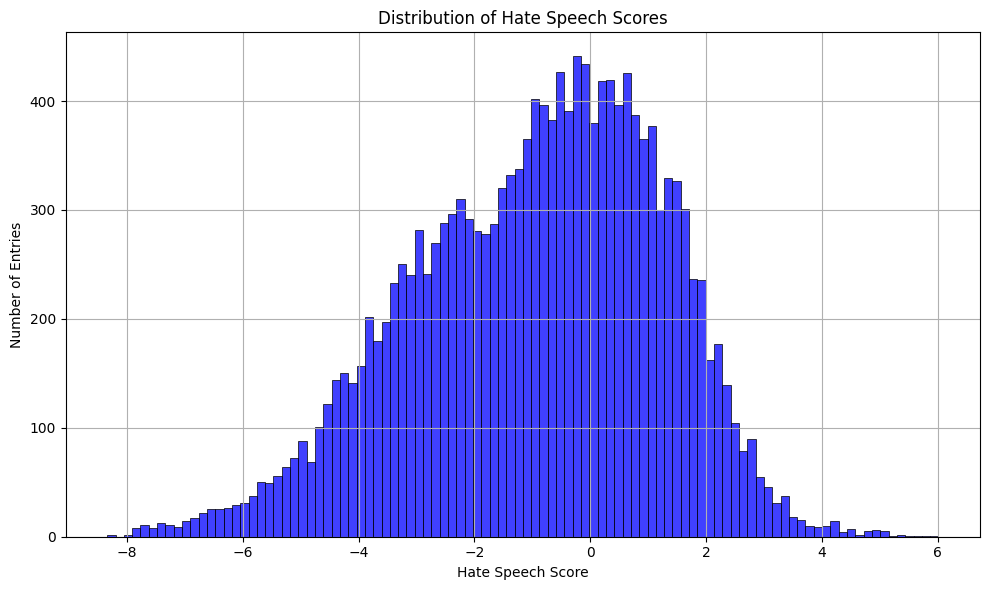

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `parsed_extractions_df` contains the hate speech scores
# If it's in a different DataFrame, adjust accordingly

# Plot histogram of hate speech scores
plt.figure(figsize=(10, 6))
sns.histplot(
    data=tokenised_df,
    x="hate_speech_score",
    bins=100,
    stat="count",
    kde=False,
    color="blue"
)

plt.xlabel("Hate Speech Score")
plt.ylabel("Number of Entries")
plt.title("Distribution of Hate Speech Scores")
plt.grid(True)
plt.tight_layout()

# Save plot
output_path = "data_distribution.png"
plt.savefig(output_path, dpi=300)
plt.show()


## tokenise

In [8]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get POS tags compatible with WordNet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()  # Get first letter of POS tag
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to NOUN

def get_tokens(example):
    # # Define regex for tokenization
    # pattern = r'''(?x)  # inline variant of VERBOSE flag
    #     \$?\d+(?:\.\d+)?  # currency amounts in regex
    #     | (?:[A-Z]\.)+    # abbreviations
    #     | \w+             # any sequence of word characters
    #     | [^\w\s]+        # sequences of punctuation
    # '''
    # 
    # # Tokenize text
    # tokens = nltk.tokenize.regexp_tokenize(example['text'], pattern)
    tokens = nltk.word_tokenize(example['text'])
    # 
    # Remove punctuation, convert to lowercase, and filter emojis
    tokens = [token.strip(string.punctuation).lower() for token in tokens]
    tokens = [token for token in tokens if token and token.isascii()]
    example['tokens'] = tokens
    return example

def get_string_tokens(example):
    example['string_tokens'] = ' '.join(example['tokens'])
    return example

tokenised_df = tokenised_df.apply(get_tokens, axis=1)

In [9]:
tokenised_df = tokenised_df.apply(get_string_tokens, axis=1)

In [10]:
def get_lemmas(example):
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in example['tokens']]
    example['lemmas'] = lemmatized_tokens
    return example

tokenised_df = tokenised_df.apply(get_lemmas, axis=1)

In [11]:
print(tokenised_df)

                                                    text  hate_speech_score  \
0      ! thank u! im transmasc and generally present ...              -3.92   
1                              !Go fuck yourself faggot!               2.47   
2                   !flair [I love women and minorities]              -4.48   
3                 !flair [death to all niggers and gays]               3.28   
4      " *gulhfg* that's the sound of your mom suckin...               1.81   
...                                                  ...                ...   
15834   😉 First time posting here. I'll post more Asians              -1.22   
15835  😍😍😍my God ur beautiful and Middle Eastern is e...              -3.83   
15836                        🤡 gas yourself not the jews               1.98   
15837  🤣🤣🤣🤣 disgusting sick gay fag, you deserve this...               1.62   
15838  🤧  The limousine liberal Jews and WASPs who wa...               1.99   

                                                  t

In [12]:
def weighted_hatespeech_score(df, column):
    """
    Given a DataFrame with columns ['text', 'hate_speech_score'],
    compute per-word stats:
      1. The average hate_speech_score (avg_score).
      2. The frequency (count of occurrences) of each word.
      3. A weighted score = avg_score * frequency.

    Returns a DataFrame with columns:
        ['avg_score', 'frequency', 'weighted_score']
    indexed by the word.
    """
    # Store data in a dict of the form:
    # { word: {"scores": [...], "count": int} }
    word_data = defaultdict(lambda: {'scores': [], 'count': 0})

    for _, row in df.iterrows():
        score = row['hate_speech_score']
        text = row[column]

        # Simple whitespace-based tokenization
        words = text

        for w in words:
            word_data[w]['scores'].append(score)
            word_data[w]['count'] += 1

    results = []
    for word, data in word_data.items():
        # Compute average score for the word
        avg_score = sum(data['scores']) / len(data['scores'])

        # Weighted measure: multiply the average by the frequency
        weighted_score = avg_score * data['count']

        results.append((
            word,
            avg_score,
            data['count'],
            weighted_score
        ))

    # Build results DataFrame
    df_results = (pd.DataFrame(
        results,
        columns=['word', 'avg_score', 'frequency', 'weighted_score']
    ))
#.set_index('word'))

    # Sort by weighted_score descending, so higher-impact words appear first
    df_results.sort_values(by='weighted_score', ascending=False, inplace=True)

    return df_results


In [13]:
word_scores_df = weighted_hatespeech_score(tokenised_df, 'lemmas')

In [198]:
# Print the top 20 words by normalized weighted score
print(word_scores_df.head(50))

# Print the bottom 20 words by normalized weighted score
print(word_scores_df.tail(50))

            word  avg_score  frequency  weighted_score
37          fuck   0.471938       3900         1840.56
39        faggot   1.313870        540          709.49
264        bitch   0.929861        722          671.36
161         cunt   1.149335        526          604.55
147       retard   1.095722        395          432.81
245        whore   1.284643        308          395.67
193           as   0.406596        799          324.87
46        nigger   1.596283        191          304.89
130         slut   1.063688        263          279.75
60          shit   0.197239       1007          198.62
691         dumb   0.764715        246          188.12
562          fag   0.955604        182          173.92
548       stupid   0.457465        355          162.40
444        piece   0.672403        233          156.67
835         hole   0.633964        222          140.74
229          fat   0.560383        235          131.69
1060        shut   0.692021        188          130.10
411    wor

In [212]:
words_freq_sorted_df = sorted_word_scores_df = word_scores_df.sort_values(by="weighted_score", ascending=False)

top_100 = word_scores_df.sort_values(by="weighted_score", ascending=False).head(100)
bottom_100 = word_scores_df.sort_values(by="weighted_score", ascending=True).head(100)

# Export to CSV
top_path = "top_100_words_by_weighted_score.csv"
bottom_path = "bottom_100_words_by_weighted_score.csv"

top_100[["word", "weighted_score"]].to_csv(top_path, index=False)
bottom_100[["word", "weighted_score"]].to_csv(bottom_path, index=False)

## Part of speech tagging

In [15]:
# pos_df = tokenised_df.copy()
# pos_df['tags'] = pos_df['tokens'].apply(nltk.pos_tag)

# Load the small English model
nlp = spacy.load("en_core_web_sm")

# Apply spaCy NLP pipeline to your DataFrame
def spacy_pos_tag(text):
    doc = nlp(text)
    return [(token.text.lower(), token.tag_) for token in doc if token.is_ascii and token.is_alpha]  # tag_ gives detailed POS tags


In [16]:
pos_df = tokenised_df.copy()
pos_df['tags'] = pos_df['text'].apply(spacy_pos_tag)

In [17]:
print(pos_df)

                                                    text  hate_speech_score  \
0      ! thank u! im transmasc and generally present ...              -3.92   
1                              !Go fuck yourself faggot!               2.47   
2                   !flair [I love women and minorities]              -4.48   
3                 !flair [death to all niggers and gays]               3.28   
4      " *gulhfg* that's the sound of your mom suckin...               1.81   
...                                                  ...                ...   
15834   😉 First time posting here. I'll post more Asians              -1.22   
15835  😍😍😍my God ur beautiful and Middle Eastern is e...              -3.83   
15836                        🤡 gas yourself not the jews               1.98   
15837  🤣🤣🤣🤣 disgusting sick gay fag, you deserve this...               1.62   
15838  🤧  The limousine liberal Jews and WASPs who wa...               1.99   

                                                  t

In [18]:
# separate nouns and verbs
pos_df['nouns'] = pos_df['tags'].apply(lambda row: [tag[0] for tag in row if tag[1].startswith("NN")])

# Define the contraction replacements
contraction_map = {"m": "am", "s": "is", "ll": "will", "re": "are", "ve": "have"}

# Extract verbs and replace contractions
pos_df['verbs'] = pos_df['tags'].apply(
    lambda row: [contraction_map.get(tag[0], tag[0]) for tag in row if tag[1].startswith("VB")]
)

In [19]:
print(pos_df)

                                                    text  hate_speech_score  \
0      ! thank u! im transmasc and generally present ...              -3.92   
1                              !Go fuck yourself faggot!               2.47   
2                   !flair [I love women and minorities]              -4.48   
3                 !flair [death to all niggers and gays]               3.28   
4      " *gulhfg* that's the sound of your mom suckin...               1.81   
...                                                  ...                ...   
15834   😉 First time posting here. I'll post more Asians              -1.22   
15835  😍😍😍my God ur beautiful and Middle Eastern is e...              -3.83   
15836                        🤡 gas yourself not the jews               1.98   
15837  🤣🤣🤣🤣 disgusting sick gay fag, you deserve this...               1.62   
15838  🤧  The limousine liberal Jews and WASPs who wa...               1.99   

                                                  t

In [20]:
# import json
# import pandas as pd
# from pycorenlp import StanfordCoreNLP
#
# def extract_thematic_roles(df, text_col="text", server_url="http://localhost:9000"):
#     # Connect to the CoreNLP server
#     nlp = StanfordCoreNLP(server_url)
#
#     # Include natlog as recommended by CoreNLP for OpenIE
#     properties = {
#         'annotators': 'tokenize,ssplit,pos,lemma,depparse,natlog,openie',
#         'outputFormat': 'json'
#     }
#
#     def process_text(text):
#         # Annotate the text
#         response = nlp.annotate(text, properties=properties)
#         # If response is a string, convert it to a dict
#         if isinstance(response, str):
#             response = json.loads(response)
#         # For debugging, print keys to check if "openie" exists:
#         print("DEBUG keys for:", text, list(response.keys()))
#         triples = []
#         if isinstance(response, dict) and "sentences" in response:
#             for sentence in response["sentences"]:
#                 if "openie" in sentence:
#                     for triple in sentence["openie"]:
#                         triples.append(triple)
#         return triples
#
#     # Apply processing to each row in the DataFrame
#     df["thematic_roles"] = df[text_col].apply(process_text)
#     return df
#
# # Example usage:
# data = {"text": ["John sold the car to Mary.", "Alice gave Bob a book.", " I sold Mary a car."]}
# pos_df = pd.DataFrame(data)
#
# # Extract thematic roles
# result_df = extract_thematic_roles(pos_df)
# print(result_df[["text", "thematic_roles"]])


In [21]:
print(pos_df)

                                                    text  hate_speech_score  \
0      ! thank u! im transmasc and generally present ...              -3.92   
1                              !Go fuck yourself faggot!               2.47   
2                   !flair [I love women and minorities]              -4.48   
3                 !flair [death to all niggers and gays]               3.28   
4      " *gulhfg* that's the sound of your mom suckin...               1.81   
...                                                  ...                ...   
15834   😉 First time posting here. I'll post more Asians              -1.22   
15835  😍😍😍my God ur beautiful and Middle Eastern is e...              -3.83   
15836                        🤡 gas yourself not the jews               1.98   
15837  🤣🤣🤣🤣 disgusting sick gay fag, you deserve this...               1.62   
15838  🤧  The limousine liberal Jews and WASPs who wa...               1.99   

                                                  t

In [204]:
pos_df["text_length"] = pos_df["text"].apply(lambda x: len(str(x).split()))l

/var/folders/ws/94nxr4hn0h958g2tjwnjtlxh0000gn/T/ipykernel_85132/3654384015.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_text_lengths, x="speech_category", y="text_length", order=category_order, palette="muted")


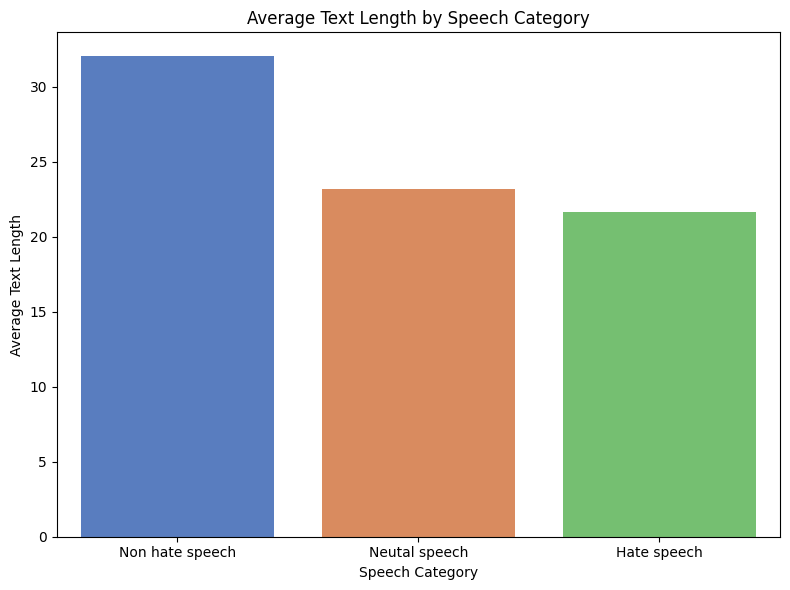

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check if the DataFrame is loaded; if not, we'll create a placeholder

df = pos_df.copy()

# Categorize the entries
def categorize_hs(score):
    if score > 0.5:
        return "Hate speech"
    elif score < -1:
        return "Non hate speech"
    else:
        return "Neutal speech"

df["speech_category"] = df["hate_speech_score"].apply(categorize_hs)

# Compute average text length per category
avg_text_lengths = df.groupby("speech_category")["text_length"].mean().reset_index()

# Reorder the categories to bring 'regular_speech' to the center
category_order = ["Non hate speech", "Neutal speech", "Hate speech"]

# Plot again with the new order
plt.figure(figsize=(8, 6))
sns.barplot(data=avg_text_lengths, x="speech_category", y="text_length", order=category_order, palette="muted")
plt.xlabel("Speech Category")
plt.ylabel("Average Text Length")
plt.title("Average Text Length by Speech Category")
plt.tight_layout()

# Save updated plot
output_path = "speech_category_text_len.png"
plt.savefig(output_path, dpi=300)
plt.show()


In [218]:
### Noun Verb Count Function
import pandas as pd

# 1) Flatten (explode) each column
nouns_exploded = pos_df.explode('nouns')   # turn list-like nouns into one entry per row
verbs_exploded = pos_df.explode('verbs')   # same for verbs

# 2) Count how often each noun appears
noun_counts = nouns_exploded['nouns'].value_counts().reset_index()
noun_counts.columns = ['noun', 'frequency']

# 3) Count how often each verb appears
verb_counts = verbs_exploded['verbs'].value_counts().reset_index()
verb_counts.columns = ['verb', 'frequency']

# Merge nouns with scores
nouns_with_score = noun_counts.merge(
    word_scores_df[['word', 'weighted_score']],
    how='left',
    left_on='noun',
    right_on='word'
)

# Merge verbs with scores (use 'verb' instead of 'noun')
verbs_with_score = verb_counts.merge(
    word_scores_df[['word', 'weighted_score']],
    how='left',
    left_on='verb',      # <-- CHANGE HERE
    right_on='word'
)

print(nouns_with_score.head())
print(verbs_with_score.head())
# 1) Sort descending for top 100
top_100_nouns = nouns_with_score.sort_values(by="weighted_score", ascending=False).head(100)
top_100_nouns[['noun','weighted_score']].to_csv("top_100_nouns.csv", index=False)

# 2) Sort ascending for bottom 100
bottom_100_nouns = nouns_with_score.sort_values(by="weighted_score", ascending=True).head(100)
bottom_100_nouns[['noun','weighted_score']].to_csv("bottom_100_nouns.csv", index=False)
# 1) Sort descending for top 100 verbs
top_100_verbs = verbs_with_score.sort_values(by="weighted_score", ascending=False).head(100)
top_100_verbs[['verb','weighted_score']].to_csv("top_100_verbs.csv", index=False)

# 2) Sort ascending for bottom 100 verbs
bottom_100_verbs = verbs_with_score.sort_values(by="weighted_score", ascending=True).head(100)
bottom_100_verbs[['verb','weighted_score']].to_csv("bottom_100_verbs.csv", index=False)


     noun  frequency    word  weighted_score
0  people       2489  people        -4519.61
1   women       1331     NaN             NaN
2    fuck       1001    fuck         1840.56
3    shit        879    shit          198.62
4     ass        766     ass           12.90
   verb  frequency  word  weighted_score
0    is       5675   NaN             NaN
1   are       4122   NaN             NaN
2    be       3038    be       -28691.30
3    do       2884    do        -6981.04
4  have       2555  have        -6965.63


In [22]:
import json
import pandas as pd
from pycorenlp import StanfordCoreNLP

def extract_thematic_roles(df, text_col="text", server_url="http://localhost:9000"):
    # Connect to the CoreNLP server
    nlp = StanfordCoreNLP(server_url)

    # Request all necessary annotators, including natlog for proper OpenIE extractions.
    properties = {
        'annotators': 'tokenize,ssplit,pos,lemma,depparse,natlog,openie',
        'outputFormat': 'json'
    }

    def process_text(text):
        response = nlp.annotate(text, properties=properties)
        # Convert to dict if needed.
        if isinstance(response, str):
            response = json.loads(response)
        triples = []
        if isinstance(response, dict) and "sentences" in response:
            for sentence in response["sentences"]:
                if "openie" in sentence:
                    for triple in sentence["openie"]:
                        triples.append(triple)
        return triples

    df["thematic_roles"] = df[text_col].apply(process_text)
    return df

def label_tokens_for_text(tokens, thematic_roles):
    """
    Given a list of tokens and a list of OpenIE triples,
    assign each token a label (in BIO format) based on the union of all spans.

    The priority is: subject > relation > object.
    Tokens outside any span are marked as "O".
    """
    subject_set = set()
    relation_set = set()
    object_set = set()

    for triple in thematic_roles:
        if "subjectSpan" in triple:
            s_start, s_end = triple["subjectSpan"]
            subject_set.update(range(s_start, s_end))
        if "relationSpan" in triple:
            r_start, r_end = triple["relationSpan"]
            relation_set.update(range(r_start, r_end))
        if "objectSpan" in triple:
            o_start, o_end = triple["objectSpan"]
            object_set.update(range(o_start, o_end))

    # Assign a preliminary role to each token with priority subject > relation > object.
    prelim = []
    for i in range(len(tokens)):
        if i in subject_set:
            prelim.append("subject")
        elif i in relation_set:
            prelim.append("relation")
        elif i in object_set:
            prelim.append("object")
        else:
            prelim.append("O")

    # Convert to BIO format: mark the beginning of each segment with "B-" and continuation with "I-"
    labels = []
    for i, role in enumerate(prelim):
        if role == "O":
            labels.append("O")
        else:
            if i == 0 or prelim[i-1] != role:
                labels.append("B-" + role)
            else:
                labels.append("I-" + role)
    return labels

def add_token_labels(df):
    """
    Assumes the DataFrame has a "tokens" column and a "thematic_roles" column.
    Adds a new column "token_labels" that contains the BIO labels for each token.
    Supports multiple triples by taking the union of spans.
    """
    def label_row(row):
        tokens = row["tokens"]
        triples = row["thematic_roles"]
        return label_tokens_for_text(tokens, triples)
    df["token_labels"] = df.apply(label_row, axis=1)
    return df


### Stanford Subject verb obj tagger ( not used anymore )

In [23]:
# thematic_ish_df = extract_thematic_roles(pos_df,"text")
# thematic_ish_df = add_token_labels(thematic_ish_df)
# print(thematic_ish_df)

In [24]:
# print(thematic_ish_df)


### PoliteNess Markers

In [39]:
# Sample politeness markers categorized
politeness_markers = {
    "exact": [
        "please", "thank you", "thanks", "excuse me", "pardon me", "I appreciate it", "I’d really appreciate it"
    ],
    "regex": {
        "modals": r"\b(could|would|might|may)\b.*?\b(you|we|I)\b",
        "hedging": r"\b(I think|maybe|perhaps|it seems|possibly)\b",
        "apologies": r"\b(I['’]?m sorry|excuse me|pardon me|I hate to ask|I hope I['’]?m not interrupting)\b",
        "tentative": r"\b(just|a little|if you don['’]?t mind|would you mind if)\b",
        "token_agreement": r"\b(I see your point|That['’]?s a good idea|I understand what you mean),? but\b",
        "impersonalization": r"\b(it would be great if|there seems to be|one might consider|some people think)\b"
    }
}

# Function to search for politeness markers
def detect_politeness(df):
    text = df['string_tokens']
    found_markers = []

    # Check for exact matches
    for marker in politeness_markers["exact"]:
        if marker.lower() in text.lower():
            found_markers.append(marker)

    # Check for regex matches
    for category, pattern in politeness_markers["regex"].items():
        if re.search(pattern, text, re.IGNORECASE):
            found_markers.append(category)

    df["politeness markets"] = found_markers
    df["politeness count"] = len(found_markers)

    return df


In [40]:
print(pos_df)
polite_df = pos_df.apply(detect_politeness, axis=1)

                                                    text  hate_speech_score  \
0      ! thank u! im transmasc and generally present ...              -3.92   
1                              !Go fuck yourself faggot!               2.47   
2                   !flair [I love women and minorities]              -4.48   
3                 !flair [death to all niggers and gays]               3.28   
4      " *gulhfg* that's the sound of your mom suckin...               1.81   
...                                                  ...                ...   
15834   😉 First time posting here. I'll post more Asians              -1.22   
15835  😍😍😍my God ur beautiful and Middle Eastern is e...              -3.83   
15836                        🤡 gas yourself not the jews               1.98   
15837  🤣🤣🤣🤣 disgusting sick gay fag, you deserve this...               1.62   
15838  🤧  The limousine liberal Jews and WASPs who wa...               1.99   

                                                  t

In [175]:
filtered_polite_df = polite_df[(polite_df['politeness count'] >= 1) & (polite_df['hate_speech_score'] > 1)]

# Select only the relevant columns
export_df = filtered_polite_df[['text', 'hate_speech_score']]

# Save to CSV
export_path = "/Users/souparna/Desktop/DiyaDiss/polite_high_hs_texts.csv"
export_df.to_csv(export_path, index=False)

export_path

'/Users/souparna/Desktop/DiyaDiss/polite_high_hs_texts.csv'

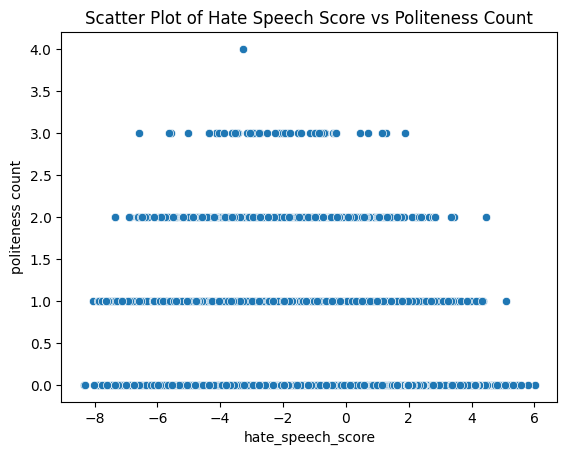

In [50]:
## Plot the Data
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=polite_df, x="hate_speech_score", y="politeness count")
plt.title("Scatter Plot of Hate Speech Score vs Politeness Count")
plt.savefig("seaborn_scatter_plot.png", dpi=300, bbox_inches="tight")
plt.show()


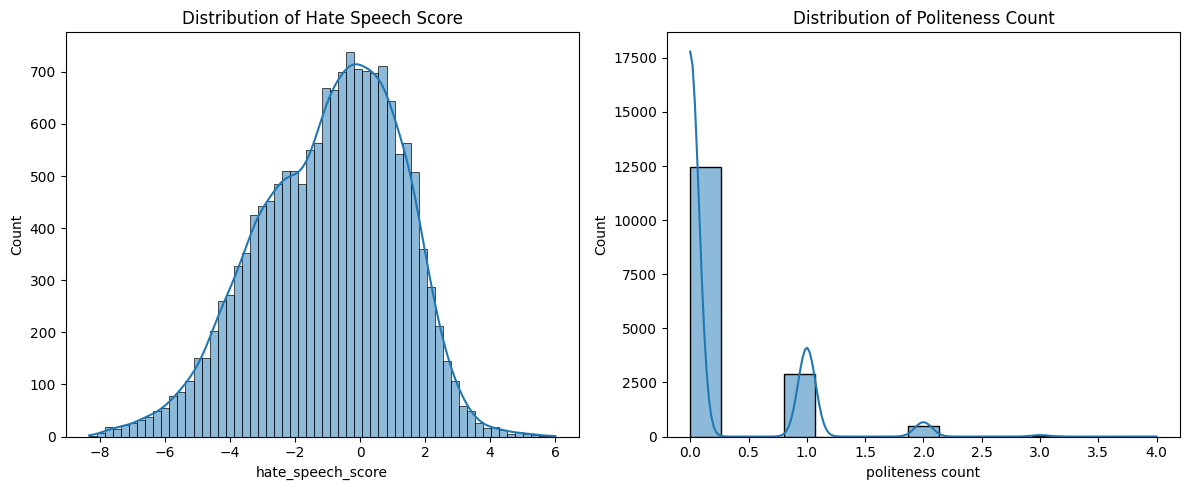

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution (histogram + KDE) of hate_speech_score
sns.histplot(polite_df["hate_speech_score"], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Hate Speech Score")

# Distribution (histogram + KDE) of politeness_count
sns.histplot(polite_df["politeness count"], kde=True, ax=axes[1])
axes[1].set_title("Distribution of Politeness Count")

plt.tight_layout()
plt.savefig("individual_distributions.png", dpi=300, bbox_inches="tight")
plt.show()


/var/folders/ws/94nxr4hn0h958g2tjwnjtlxh0000gn/T/ipykernel_85132/2905896511.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = polite_df.groupby("hs_bin")["politeness count"].mean().reset_index()


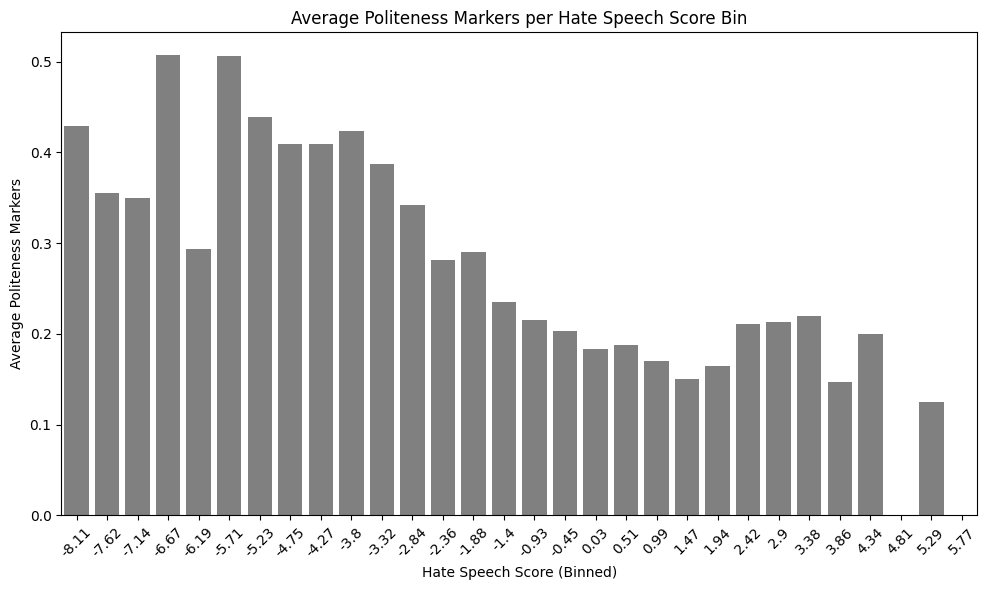

In [174]:
# import seaborn as sns
# import matplotlib.pyplot as plt
#
# plt.figure(figsize=(8,6))
#
# # This will bin hate_speech_score and sum politeness_count within each bin.
# sns.histplot(
#     data=polite_df,
#     x="hate_speech_score",
#     weights="politeness count",  # We sum these values in each bin
#     bins=30,                     # Adjust as needed
#     stat="count",                # 'count' here means "sum of weights" when 'weights' is given
#     color="grey"
# )
#
# plt.xlabel("Hate Speech Score")
# plt.ylabel("Total Politeness Markers")
# plt.title("Total Politeness Markers per Hate Speech Score Bin")
# plt.savefig("yay.png",dpi=300, bbox_inches="tight")
# plt.show()

# Bin the hate_speech_score into 30 bins
polite_df["hs_bin"] = pd.cut(polite_df["hate_speech_score"], bins=30)

# Group by bins and calculate mean politeness count
bin_stats = polite_df.groupby("hs_bin")["politeness count"].mean().reset_index()

# Midpoint for x-axis labels
bin_stats["bin_center"] = bin_stats["hs_bin"].apply(lambda x: round(x.mid,2))
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    x="bin_center",
    y="politeness count",
    data=bin_stats,
    color="grey"
)

plt.xlabel("Hate Speech Score (Binned)")
plt.ylabel("Average Politeness Markers")
plt.title("Average Politeness Markers per Hate Speech Score Bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("avg_politeness_per_bin.png", dpi=300)
plt.show()




### In Group Out Group

In [67]:
import re

# Sample group markers
group_markers = {
    "in_group": {
        "pronouns": r"\b(we|us|our|ours|ourselves)\b",
        "solidarity_terms": r"\b(fellow|comrades|brothers|sisters|kin|friends)\b"
    },
    "out_group": {
        "pronouns": r"\b(they|them|their|theirs|themselves)\b",
        "othering": r"\b(those people|that lot|outsiders|foreigners|their kind)\b"
    }
}

def detect_groups(df):
    text = df["string_tokens"]

    in_group_found = []
    out_group_found = []

    # Check in_group markers
    for category, pattern in group_markers["in_group"].items():
        if re.search(pattern, text, re.IGNORECASE):
            in_group_found.append(category)

    # Check out_group markers
    for category, pattern in group_markers["out_group"].items():
        if re.search(pattern, text, re.IGNORECASE):
            out_group_found.append(category)

    # Store results in new columns
    df["in_group_markers"] = in_group_found
    df["in_group_count"] = len(in_group_found)

    df["out_group_markers"] = out_group_found
    df["out_group_count"] = len(out_group_found)

    return df


In [68]:
groups_df = polite_df.apply(detect_groups, axis=1)


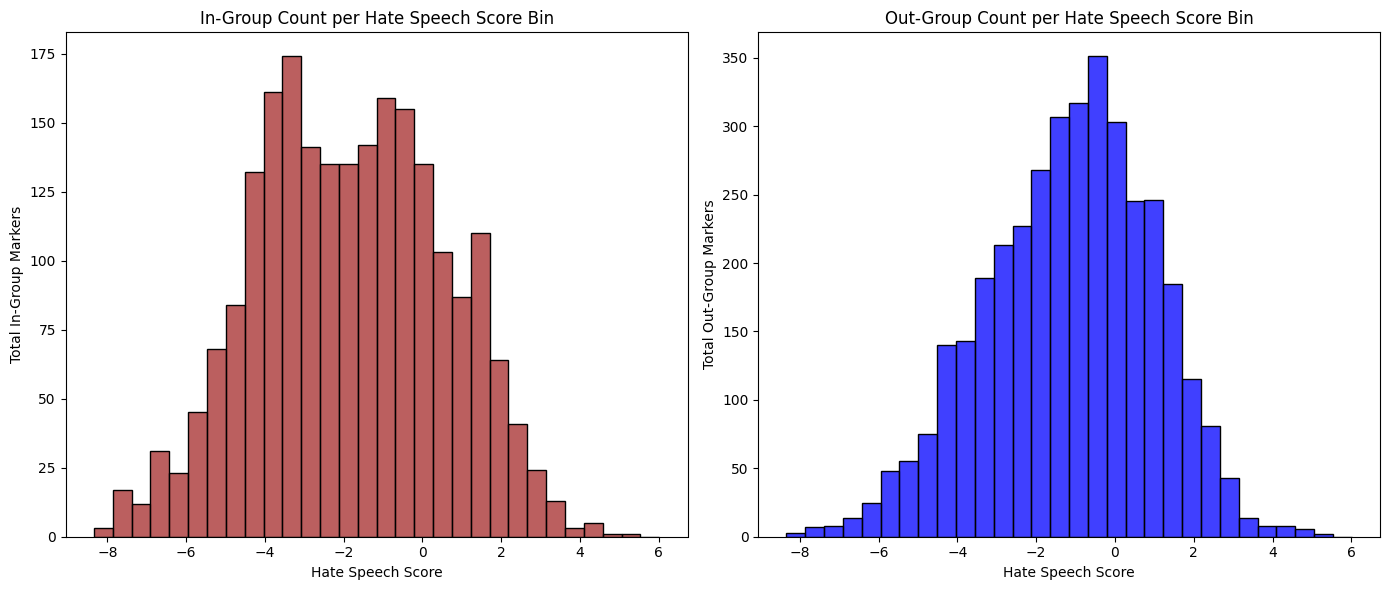

In [78]:
### Plot it
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Left subplot: In-group count distribution by hate speech score
plt.subplot(1, 2, 1)
sns.histplot(
    data=groups_df,
    x="hate_speech_score",
    weights="in_group_count",  # Sum of in_group markers in each bin
    bins=30,                   # Adjust the number of bins as needed
    stat="count",              # Sum of weights per bin
    color="brown"
)
plt.xlabel("Hate Speech Score")
plt.ylabel("Total In-Group Markers")
plt.title("In-Group Count per Hate Speech Score Bin")

# Right subplot: Out-group count distribution by hate speech score
plt.subplot(1, 2, 2)
sns.histplot(
    data=groups_df,
    x="hate_speech_score",
    weights="out_group_count",  # Sum of out_group markers in each bin
    bins=30,
    stat="count",
    color="blue"
)
plt.xlabel("Hate Speech Score")
plt.ylabel("Total Out-Group Markers")
plt.title("Out-Group Count per Hate Speech Score Bin")

plt.tight_layout()
plt.savefig("group_counts_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


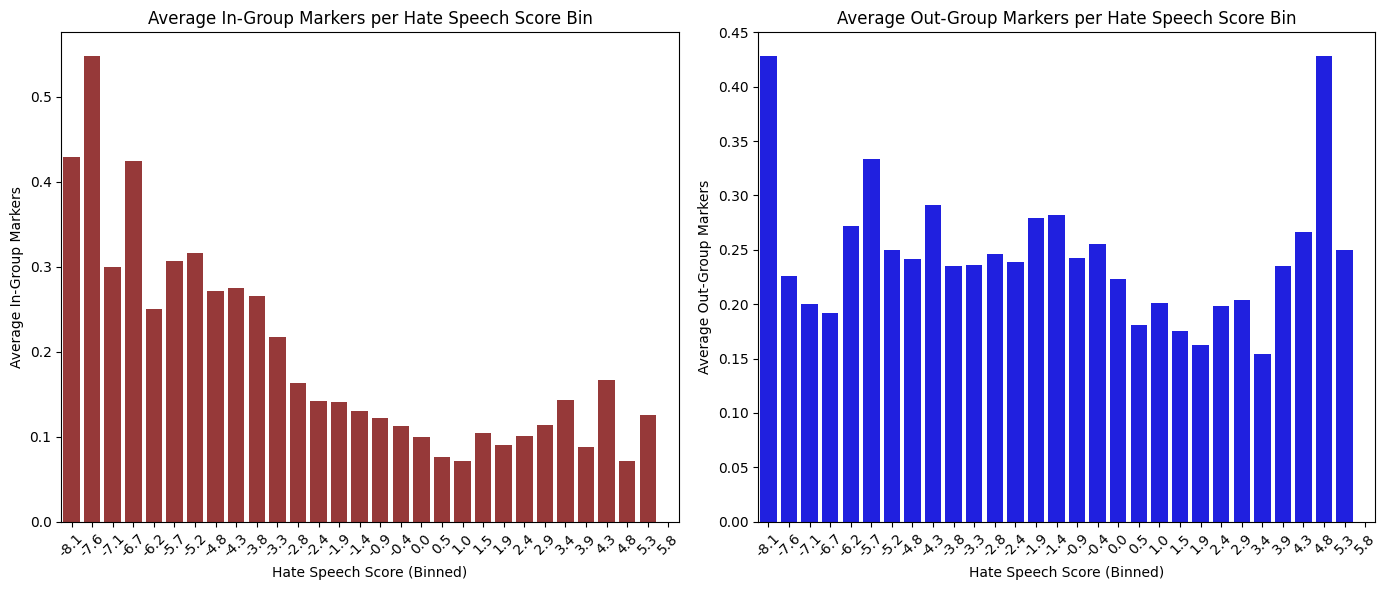

In [178]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Bin the hate_speech_score into 30 bins
groups_df["hs_bin"] = pd.cut(groups_df["hate_speech_score"], bins=30)

# Group by bins and calculate the mean (average) group markers
bin_group_stats = groups_df.groupby("hs_bin", observed=True).agg({
    "in_group_count": "mean",
    "out_group_count": "mean"
}).reset_index()

# Compute midpoints for better x-axis labels
bin_group_stats["bin_center"] = bin_group_stats["hs_bin"].apply(lambda x: round(x.mid,1))

# Plotting
plt.figure(figsize=(14, 6))

# Left: Average In-Group markers per bin
plt.subplot(1, 2, 1)
sns.barplot(
    x="bin_center",
    y="in_group_count",
    data=bin_group_stats,
    color="brown"
)
plt.xlabel("Hate Speech Score (Binned)")
plt.ylabel("Average In-Group Markers")
plt.title("Average In-Group Markers per Hate Speech Score Bin")
plt.xticks(rotation=45)

# Right: Average Out-Group markers per bin
plt.subplot(1, 2, 2)
sns.barplot(
    x="bin_center",
    y="out_group_count",
    data=bin_group_stats,
    color="blue"
)
plt.xlabel("Hate Speech Score (Binned)")
plt.ylabel("Average Out-Group Markers")
plt.title("Average Out-Group Markers per Hate Speech Score Bin")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("avg_group_marker_counts_per_bin.png", dpi=300)
plt.show()


In [ ]:
print(groups_df)

### Working ALENLP Themantic Analysis

In [164]:
themantised_df = pd.read_csv("themantised.csv")

In [165]:
print(themantised_df)

       Unnamed: 0                                               text  \
0               0  ! thank u! im transmasc and generally present ...   
1               1                          !Go fuck yourself faggot!   
2               2               !flair [I love women and minorities]   
3               3             !flair [death to all niggers and gays]   
4               4  " *gulhfg* that's the sound of your mom suckin...   
...           ...                                                ...   
15834       15834   😉 First time posting here. I'll post more Asians   
15835       15835  😍😍😍my God ur beautiful and Middle Eastern is e...   
15836       15836                        🤡 gas yourself not the jews   
15837       15837  🤣🤣🤣🤣 disgusting sick gay fag, you deserve this...   
15838       15838  🤧  The limousine liberal Jews and WASPs who wa...   

       hate_speech_score                                             tokens  \
0                  -3.92  ['thank', 'u', 'im', 'transmas

In [166]:
import json
import ast
from nltk import Tree

def parse_srl_output(row):
    """
    Given a DataFrame row that contains a column 'srl_output' (which should be a dict with keys "words" and "verbs"),
    return a list of extractions. Each extraction is a dict with:
      - 'verb': the predicate word
      - 'roles': a dictionary mapping role labels (e.g., ARG0, V, ARG1, ARGM-CAU) to a list of extracted phrases.
    """
    result = row['srl_output']
    # If result is a string, try parsing it
    if isinstance(result, str):
        try:
            result = json.loads(result)
        except json.JSONDecodeError:
            # If JSON parsing fails, try using ast.literal_eval (works on valid Python literals)
            result = ast.literal_eval(result)
    words = result["words"]
    verb_extractions = []
    for verb_info in result["verbs"]:
        predicate = verb_info["verb"]
        tags = verb_info["tags"]
        roles = {}  # dictionary mapping role labels to list of phrases
        current_label = None
        current_tokens = []
        for i, tag in enumerate(tags):
            if tag == "O":
                if current_label is not None:
                    phrase = " ".join(current_tokens)
                    roles.setdefault(current_label, []).append(phrase)
                    current_label = None
                    current_tokens = []
                continue
            # For IOB tags: B- indicates beginning of a new span, I- continues the current span.
            prefix, label = tag.split("-", 1)
            if prefix == "B":
                if current_label is not None:
                    phrase = " ".join(current_tokens)
                    roles.setdefault(current_label, []).append(phrase)
                current_label = label
                current_tokens = [words[i]]
            elif prefix == "I":
                if current_label == label:
                    current_tokens.append(words[i])
                else:
                    if current_label is not None:
                        phrase = " ".join(current_tokens)
                        roles.setdefault(current_label, []).append(phrase)
                    current_label = label
                    current_tokens = [words[i]]
        # Finalize any active span.
        if current_label is not None and current_tokens:
            phrase = " ".join(current_tokens)
            roles.setdefault(current_label, []).append(phrase)
        verb_extractions.append({
            "verb": predicate,
            "roles": roles
        })
    return verb_extractions

def build_srl_tree(extraction: dict) :
    """
    Given an SRL extraction (with a 'verb' and 'roles' dict),
    build an NLTK Tree that represents the semantic roles.

    Example tree structure:

      SRL
      ├── Verb: <verb>
      ├── ARG0: <phrase>
      ├── ARG1: <phrase>
      └── ARGM-CAU: <phrase>
    """
    verb = extraction['verb']
    roles = extraction['roles']
    # Start with a subtree for the verb.
    children = [Tree("Verb", [verb])]
    # For each role, add a child node (or multiple if there are multiple phrases).
    for role, phrases in roles.items():
        for phrase in phrases:
            children.append(Tree(role, [phrase]))
    return Tree("SRL", children)


themantised_df["extractions"] = themantised_df.apply(parse_srl_output, axis=1)
print(themantised_df[["text", "srl_output", "extractions", "hate_speech_score"]].head())


                                                text  \
0  ! thank u! im transmasc and generally present ...   
1                          !Go fuck yourself faggot!   
2               !flair [I love women and minorities]   
3             !flair [death to all niggers and gays]   
4  " *gulhfg* that's the sound of your mom suckin...   

                                          srl_output  \
0  {'verbs': [{'verb': 'thank', 'description': '!...   
1  {'verbs': [{'verb': 'Go', 'description': '! [V...   
2  {'verbs': [{'verb': 'love', 'description': '! ...   
3  {'verbs': [], 'words': ['!', 'flair', '[', 'de...   
4  {'verbs': [{'verb': "'s", 'description': '" * ...   

                                         extractions  hate_speech_score  
0  [{'verb': 'thank', 'roles': {'V': ['thank'], '...              -3.92  
1  [{'verb': 'Go', 'roles': {'V': ['Go'], 'ARG1':...               2.47  
2  [{'verb': 'love', 'roles': {'ARG0': ['I'], 'V'...              -4.48  
3                             

In [167]:

# Optionally, build syntax trees for each extraction.
# If there are multiple extractions per sentence, you can build a list of trees.
themantised_df["srl_trees"] = themantised_df["extractions"].apply(lambda extractions: [build_srl_tree(ext) for ext in extractions])


In [168]:
def print_thematic(id):
    # Print the sentence from the first row.
    print("Sentence:", themantised_df["text"].iloc[id])

    # Retrieve the list of syntax trees for the first row.
    extractions = themantised_df["srl_trees"].iloc[id]

    # Print the number of extractions.
    print("Number of extractions:", len(extractions))

    # Print each tree.
    for i, tree in enumerate(extractions):
        print(f"\nExtraction {i+1}:")
        tree.pretty_print()




In [179]:
### Processing the extractions column in the thematised_df
new_rows = []

# Iterate through each row of the DataFrame
for idx, row in themantised_df.iterrows():
    sentence = row['text']
    raw_hate_score = row.get('hate_speech_score', None)  # Adjust if your hate speech score column has a different name

    # Iterate through each extraction in this row
    for extraction in row['extractions']:
        roles = extraction['roles']
        new_row = {
            'sentence': sentence,
            'verb': extraction['verb'],
            'ARG0': roles.get('ARG0', [None])[0],
            'ARG1': roles.get('ARG1', [None])[0],
            'ARG2': roles.get('ARG2', [None])[0],
            'Raw_Hate_Speech': raw_hate_score
        }
        new_rows.append(new_row)

# Create the new DataFrame
parsed_extractions_df = pd.DataFrame(new_rows)

### Analysis of Thematic Roles Arg0, Arg1 and Arg2 distribution vs hate speech

In [181]:
print(parsed_extractions_df.head())

                                            sentence       verb  ARG0  \
0  ! thank u! im transmasc and generally present ...      thank  None   
1  ! thank u! im transmasc and generally present ...          m  None   
2  ! thank u! im transmasc and generally present ...       look     i   
3  ! thank u! im transmasc and generally present ...        was  None   
4  ! thank u! im transmasc and generally present ...  wondering     i   

                      ARG1       ARG2  Raw_Hate_Speech ARG0_nouns ARG1_nouns  \
0                        u       None            -3.92         []        [u]   
1                        i  transmasc            -3.92         []        [i]   
2                a bit gay       None            -3.92        [i]      [bit]   
3                     None       None            -3.92         []         []   
4  about how that would go       None            -3.92        [i]         []   

    ARG2_nouns  
0           []  
1  [transmasc]  
2           []  
3           

In [183]:
from collections import Counter
import pandas as pd

# Simulate loading the DataFrame (assuming it's already defined in your environment)
# parsed_extractions_df = pd.read_csv("parsed_extractions_with_nouns.csv")

# Flatten and lowercase all nouns per role
arg0_words = [word.lower() for sublist in parsed_extractions_df['ARG0_nouns'].dropna() for word in sublist]
arg1_words = [word.lower() for sublist in parsed_extractions_df['ARG1_nouns'].dropna() for word in sublist]
arg2_words = [word.lower() for sublist in parsed_extractions_df['ARG2_nouns'].dropna() for word in sublist]

# Count frequencies
arg0_counts = Counter(arg0_words)
arg1_counts = Counter(arg1_words)
arg2_counts = Counter(arg2_words)

# Get all unique words from all roles
all_words = set(arg0_counts) | set(arg1_counts) | set(arg2_counts)

# Build a new DataFrame
noun_freq_df = pd.DataFrame({
    "word": list(all_words),
    "ARG0_count": [arg0_counts.get(w, 0) for w in all_words],
    "ARG1_count": [arg1_counts.get(w, 0) for w in all_words],
    "ARG2_count": [arg2_counts.get(w, 0) for w in all_words]
})

# Calculate Thematic Role Ratios
noun_freq_df["total"] = noun_freq_df["ARG0_count"] + noun_freq_df["ARG1_count"] + noun_freq_df["ARG2_count"]
noun_freq_df["ARG0_ratio"] = noun_freq_df["ARG0_count"] / noun_freq_df["total"]
noun_freq_df["ARG1_ARG2_ratio"] = (noun_freq_df["ARG1_count"] + noun_freq_df["ARG2_count"]) / noun_freq_df["total"]



In [184]:
print(noun_freq_df.head)

<bound method NDFrame.head of           word  ARG0_count  ARG1_count  ARG2_count  total  ARG0_ratio  \
0          win           0           7          13     20    0.000000   
1          t_d           0           2           0      2    0.000000   
2            😊           1           2           0      3    0.333333   
3      lungren           0           2           0      2    0.000000   
4          wit           0           0           3      3    0.000000   
...        ...         ...         ...         ...    ...         ...   
12753        n           1          30           5     36    0.027778   
12754  sarongs           0           2           0      2    0.000000   
12755    mmmmm           0           1           0      1    0.000000   
12756     army           9          11           5     25    0.360000   
12757   hewitt           0           1           0      1    0.000000   

       ARG1_ARG2_ratio  
0             1.000000  
1             1.000000  
2             0.66

In [185]:
noun_freq_hs_df = noun_freq_df.merge(word_scores_df[['word', 'weighted_score']], on='word', how='left')

In [194]:
noun_freq_hs_df_interesting = noun_freq_hs_df[['word','ARG0_ratio','ARG1_ARG2_ratio','weighted_score']]
print(noun_freq_hs_df_interesting.head())

      word  ARG0_ratio  ARG1_ARG2_ratio  weighted_score
0      win    0.000000         1.000000          -67.26
1      t_d    0.000000         1.000000            2.27
2        😊    0.333333         0.666667             NaN
3  lungren    0.000000         1.000000           -1.73
4      wit    0.000000         1.000000           -4.89


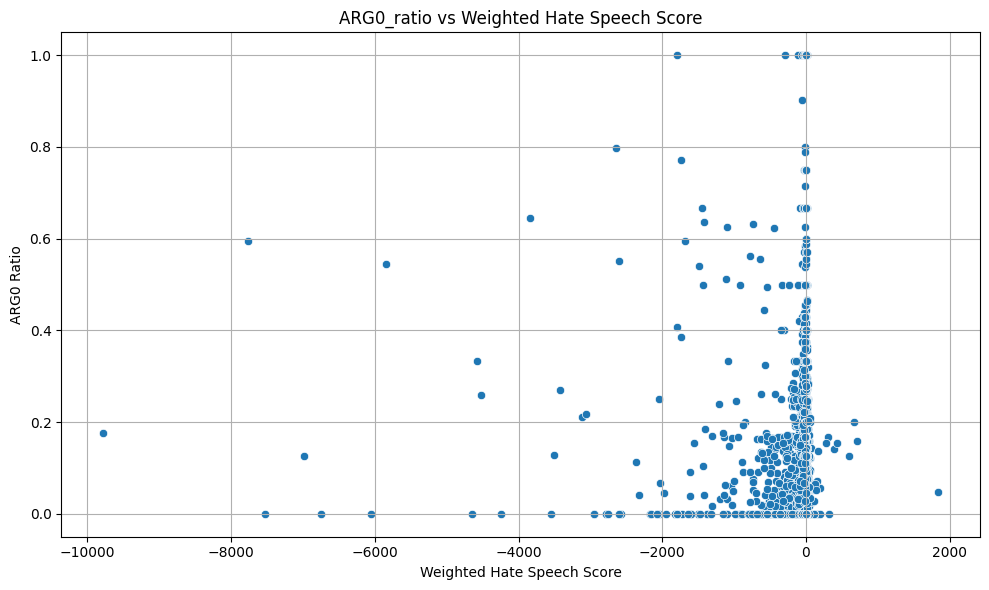

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows with missing weighted_score or ratio values
plot_df = noun_freq_hs_df.dropna(subset=["weighted_score", "ARG0_ratio"])

# Further filter to scores between -10000 and 10000
plot_df = plot_df[(plot_df["weighted_score"] >= -10000) & (plot_df["weighted_score"] <= 10000)]

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x="weighted_score",
    y="ARG0_ratio"
)

plt.xlabel("Weighted Hate Speech Score")
plt.ylabel("ARG0 Ratio")
plt.title("ARG0_ratio vs Weighted Hate Speech Score")
plt.grid(True)
plt.tight_layout()
plt.savefig("scatter_thematic_ARG0_HS", dpi=300)
plt.show()

In [157]:
print_thematic(9009)

Sentence: Oh god.  Everything. All of my problems right now have to deal with me being trans. If I was acid woman I would have literally no problems on my life and I'd be the happiest I've ever been.  Literally the only thing I've prayed for in the past two years is to wake up as a cis woman
Number of extractions: 14

Extraction 1:
     SRL     
  ____|___    
Verb      V  
 |        |   
have     have


Extraction 2:
           SRL                           
  __________|____________________         
Verb       ARG0        V        ARG1     
 |          |          |         |        
deal All of my proble deal with me being 
            ms                 trans     


Extraction 3:
      SRL             
   ____|___________    
 Verb ARG1   V    ARG2
  |    |     |     |   
being  me  being trans


Extraction 4:
     SRL                
  ____|___________       
Verb ARG1  V     ARG2   
 |    |    |      |      
was   I   was acid woman


Extraction 5:
      SRL      
   ____|____    

In [156]:
from pprint import pprint

text = themantised_df.loc[9009, 'text']
test = themantised_df.loc[9009, 'extractions']
raw  = themantised_df.loc[9009, 'srl_output']
print(text)
print(json.dumps(test, indent=2))
# pprint(test)

print(raw)


Oh god.  Everything. All of my problems right now have to deal with me being trans. If I was acid woman I would have literally no problems on my life and I'd be the happiest I've ever been.  Literally the only thing I've prayed for in the past two years is to wake up as a cis woman
[
  {
    "verb": "have",
    "roles": {
      "V": [
        "have"
      ]
    }
  },
  {
    "verb": "deal",
    "roles": {
      "ARG0": [
        "All of my problems"
      ],
      "V": [
        "deal"
      ],
      "ARG1": [
        "with me being trans"
      ]
    }
  },
  {
    "verb": "being",
    "roles": {
      "ARG1": [
        "me"
      ],
      "V": [
        "being"
      ],
      "ARG2": [
        "trans"
      ]
    }
  },
  {
    "verb": "was",
    "roles": {
      "ARG1": [
        "I"
      ],
      "V": [
        "was"
      ],
      "ARG2": [
        "acid woman"
      ]
    }
  },
  {
    "verb": "would",
    "roles": {
      "V": [
        "would"
      ]
    }
  },
  {
    "ver

In [ ]:
### we looking at arg0 arg1 and arg2

### OLD THEMATIC ANALYSER FROM HERE


In [101]:
def extract_thematic_roles():
    import pandas as pd
    from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

    def extract_thematic_roles(df, text_col="text"):
        # Load the model and tokenizer from Hugging Face
        model_checkpoint = "liaad/srl-en_xlmr-large"
        tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
        model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)
        
        # Create a token classification pipeline.
        # The aggregation_strategy groups contiguous tokens with the same label.
        srl_pipeline = pipeline(
            "token-classification", 
            model=model, 
            tokenizer=tokenizer, 
            aggregation_strategy="simple"
        )
        
        # Apply the pipeline on the specified text column.
        # The output will be a list of dictionaries containing token groups and labels.
        df["srl"] = df[text_col].apply(lambda text: srl_pipeline(text))
        return df

    # Example usage:
    # Create a sample DataFrame
    data = {"text": ["John sold the car to Mary.", "Alice gave Bob a book."]}
    pos_df = pd.DataFrame(data)
    
    # Extract thematic roles
    result_df = extract_thematic_roles(pos_df, text_col="text")
    print(result_df)



extract_thematic_roles()

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ImportError: 
 requires the protobuf library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/protocolbuffers/protobuf/tree/master/python#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [ ]:
# # def extract_thematic_roles(text):
# #     '''
# #     Function to extract thematic roles using spaCy
# # 
# #     :param text: original text of tweet as str
# #     :return: list of thematic roles identified in 'text'
# #     '''
# #     doc = nlp(text)
# #     roles = {}
# #     for token in doc:
# #         if token.dep_ in ['nsubj', 'dobj', 'iobj', 'pobj', 'attr', 'agent', 'prep']:  # Common thematic roles
# #             roles[token.dep_] = token.text
# #     return roles
# 
# # Function to compare thematic roles with VerbNet classes
# 
def match_verbnet_classes(verb, sentence):
    candidates = vn.classids(verb)
    sentence_roles = extract_thematic_roles(sentence)
    best_match = None
    best_score = 0

    for candidate in candidates:
        themroles = vn.themroles(candidate)
        vn_roles = [role[0] for role in themroles]  # Extract thematic role types

        # Count the matches between extracted roles and VerbNet roles
        match_count = sum(1 for role in sentence_roles if role in vn_roles)

        if match_count > best_score:
            best_match = candidate
            best_score = match_count

    return best_match, best_score
# 
# # Apply match_verbnet_classes function to pos_df
# 
def apply_verbnet_matching(row):
    verbnet_matches = {}
    for verb in row['verb_lemmas']:
        best_class, score = match_verbnet_classes(verb, row['text'])
        if best_class is not None:
            verbnet_matches[verb] = (best_class, score)
    return verbnet_matches


In [ ]:
# pos_df['verbnet_matches'] = pos_df.apply(apply_verbnet_matching, axis=1)
# 
# # Display sample of pos_df
# pos_df.head()

In [ ]:
# verb_scores_df = weighted_hatespeech_score(pos_df, 'verb_lemmas')
# print(verb_scores_df)

In [ ]:
#### TODO SLUR FILTER

In [ ]:
# # List of slurs, derogatory words, or abusive words
# slurs_list = [
#     'bastard', 'bitch', 'cunt', 'dick', 'faggot', 'fuck', 'motherfucking', 'nigga', 'nigger', 'prick', 'slut', 'whore', 'dumb', 'inbred',
#     'retard', 'pussy', 'twat', 'wanker', 'arsehole', 'cock', 'shithead', 'tosser', 'slag', 'dyke', 'homo', 'tranny', 'cock',
#     'spaz', 'chink', 'gook', 'wetback', 'spic', 'kike', 'cracker', 'coon', 'raghead', 'redskin', 'jap', 'mick', 'kraut', 'shit'
# ]
# 
# # Function to filter out slurs from the DataFrame
# 
# def filter_slurs(df, column_name):
#     slurs_removed_df = df[~df[column_name].isin(slurs_list)]
#     return slurs_removed_df
# 
# # Apply filtering to verb_scores_df
# filtered_verb_scores_df = filter_slurs(verb_scores_df, "word")
# print(filtered_verb_scores_df)


In [ ]:
# Print the top 20 words by normalized weighted score
print(filtered_verb_scores_df.head(60))

# Print the bottom 20 words by normalized weighted score
print(filtered_verb_scores_df.tail(60))

In [ ]:
filtered_verb_scores_df['verb_class'] = filtered_verb_scores_df['word'].apply(lambda word: vn.classids(word))
print(filtered_verb_scores_df.head(50))

In [ ]:
# most common verb classes

pos_df['verb_classes'] = pos_df['verb_lemmas'].apply(
    lambda row: [vn.classids(verb) for verb in row ]
)

# pos_df = get_lemmas(pos_df, 'verbs', 'verb_lemmas')

In [ ]:
print(pos_df)

In [ ]:
# def get_verb_class(row):
#     '''
#     Extracts VerbNet classes and thematic roles for all verbs in a row.
# 
#     :param row: A single row from a DataFrame (pd.Series) containing a 'verbs' column.
#     :return: Dictionary with verb classes and their thematic roles
#     '''
#     tagged_verbs = []
# 
#     if isinstance(row, pd.Series) and 'verbs' in row and isinstance(row['verbs'], list):  
#         for verb in row['verbs']:
#             if isinstance(verb, str):  # Ensure each item is a string
#                 verb_classes = vn.classids(verb)
#                 if verb_classes:
#                     verb_class = verb_classes if verb_classes else verb
#                     tagged_verbs.append(verb_class)
#                     
#                     verb_info = []
# 
#                     # Retrieve thematic roles associated with this verb class
#                     for vn_class in verb_classes:
#                         themroles = vn_reader.themroles(vn_class)  # Get thematic roles
#                         verb_info.append({
#                             "vn_class": vn_class,
#                             "thematic_roles": [{
#                                 "type": role['type'], 
#                                 "modifiers": role.get('modifiers', {}), 
#                                 "selectional_restrictions": role.get('selrestrs')
#                             } for role in themroles]
#                         })
#                 # return verb_info
#                     
#                 #     themroles = vn.themroles(verb_class)
#                 #     if themroles:
#                 #         for role in themroles:
#                 #             role_name = role.get('themrole')
#                 #             selectional_restrictions = role.get('selrestrs')  # e.g., {'+animate'}
#                 #             verb_roles[verb].append((role_name, selectional_restrictions))
#                 # else:
#                 #     tagged_verbs.append(None)
#     
#     # Return both the classes and thematic roles for each verb
#     else:
#         verb_info = []
#     return {'verb_classes': tagged_verbs, 'verb_args': verb_info}


In [ ]:
# pos_df['verb_info'] = pos_df.apply(get_verb_class, axis=1)
# print(pos_df)

In [ ]:
# def get_verbnet_info(verb):
#     """
#     Get VerbNet class and thematic roles for a given verb.
#     """
#     vn_classes = vn_reader.classids(lemma=verb)
#     verb_info = []
#     for vn_class in vn_classes:
#         themroles = vn_reader.themroles(vn_class)  # Get thematic roles
#         verb_info.append({
#             "vn_class": vn_class,
#             "thematic_roles": [{
#                 "type": role['type'], 
#                 "modifiers": role.get('modifiers', {}), 
#                 "selectional_restrictions": role.get('selrestrs')} 
#                 for role in themroles]
#         })
#     return verb_info
# 
# # Example usage
# verb = "cause"
# info = get_verbnet_info(verb)
# print(info)

### Connectives

In [ ]:
# Causality connectives list
causality_connectives = [
    "because", "so", "therefore", "thus", "due to", "as a result", "consequently", "hence", 
    "since", "for this reason", "for that reason", "as", "owing to", "so that", "this leads to", 
    "this results in", "accordingly", "in consequence", "in view of", "on account of", "thanks to", 
    "caused by", "is why", "if", "then", "thereby", "by virtue of", "thus far", "given that", 
    "in that", "in turn", "as long as", "as a consequence", "due to the fact that", "because of", 
    "for", "in order to", "with the result that", "so as to", "such that", "as such", "from this follows", 
    "on condition that", "in effect", "leading to", "making it so", "with the effect that", "as a byproduct of",
    "resulting from", "contributing to", "with", "unless"
]

# Function to find counts of causality connectives from diff dictionary
def find_causality_connective_counts(diff, connectives):
    # Create a dictionary to store the counts for the connectives
    connective_counts = {}
    
    for word in diff:
        if word in connectives:  # Check if the word is in the list of causality connectives
            connective_counts[word] = diff[word]  # Store the diff value for that word
    
    return connective_counts

# Example diff dictionary (from your code)
# diff = { ... }  # This would be generated from your previous code

# Get the causality connective counts
causal_connective_diff_counts = find_causality_connective_counts(diff, causality_connectives)

# Print the sorted result
print(dict(sorted(causal_connective_diff_counts.items(), key=lambda item: item[1], reverse=True)))

### Noun classes

In [ ]:
def count_noun_classes(tokens):
    """
    Classifies nouns and counts occurrences in each class: proper, abstract, concrete, and animate.
    """
    noun_counts = defaultdict(int)

    def classify_noun(noun):
        synsets = wn.synsets(noun, pos=wn.NOUN)
        if not synsets:
            return "unknown"
        for synset in synsets:
            hypernyms = set(h.name() for h in synset.closure(lambda s: s.hypernyms()))
            if "physical_entity.n.01" in hypernyms:
                return "concrete"
            if "person.n.01" in hypernyms or "animal.n.01" in hypernyms:
                return "animate"
        return "abstract"

    for token in tokens:
        classification = classify_noun(token)
        noun_counts[classification] += 1

    return noun_counts

def accumulate_noun_counts(ds, hs='all'):
    total_counts = defaultdict(int)

    if hs == 'yes':
        token_lists = [row['tokens'] for row in ds if row['hate_speech_score'] >= 0.5]
    elif hs == 'no':
        token_lists = [row['tokens'] for row in ds if row['hate_speech_score'] < 0.5]
    else:
        token_lists = [row['tokens'] for row in ds]

    for tokens in token_lists:
        noun_counts = count_noun_classes(tokens)
        for noun_class, count in noun_counts.items():
            total_counts[noun_class] += count

    return total_counts

hs_noun_counts = accumulate_noun_counts(tokenised_ds, hs='yes')
non_hs_noun_counts = accumulate_noun_counts(tokenised_ds, hs='no')

print("Hate Speech Noun Counts:", hs_noun_counts)
print("Non-Hate Speech Noun Counts:", non_hs_noun_counts)

### Modals

In [ ]:
modals = ['can', 'could', 'shall', 'should', 'will', 'would', 'may', 'might', 'must']

In [ ]:
print(max(filtered_df['hate_speech_score']))

descriptive stats are ok! andrew gillman (bayesian but not ideological) - cool blog. embrace uncertainty - exploratory analyses: be open and honest about what worked and what didn't work. 

# Verbnet

In [ ]:
# def analyze_verbnet_patterns(dataset, hate_speech_filter='all'):
#     """
#     Analyze VerbNet patterns in a dataset for hate speech and non-hate speech.
#     :param dataset: List of dictionaries with 'tokens' and 'hate_speech_score'.
#     :param hate_speech_filter: 'yes', 'no', or 'all' to filter by hate speech score.
#     :return: A dictionary of counts for VerbNet classes, semantic roles, and predicates.
#     """
#     results = {
#         'verbnet_classes': defaultdict(int),
#         'semantic_roles': defaultdict(int),
#         'semantic_predicates': defaultdict(int),
#     }
# 
#     # Filter dataset based on hate speech score
#     if hate_speech_filter == 'yes':
#         token_lists = [row['tokens'] for row in dataset if row['hate_speech_score'] >= 0.5]
#     elif hate_speech_filter == 'no':
#         token_lists = [row['tokens'] for row in dataset if row['hate_speech_score'] < 0.5]
#     else:
#         token_lists = [row['tokens'] for row in dataset]
# 
#     for tokens in token_lists:
#         tagged_tokens = pos_tag(tokens)
# 
#         verbs = [token for token, tag in tagged_tokens if tag.startswith('VB')]
#         for verb in verbs:
#             try:
#                 classes = vn.classids(lemma=verb)
#                 for verb_class in classes:
#                     # Count VerbNet classes
#                     results['verbnet_classes'][verb_class] += 1
#             except Exception as e:
#                 # Handle cases where the verb doesn't have a VerbNet class
#                 print(f"Error processing verb {verb}: {e}")
#                 continue
# 
#     return results
# 
# # Analyze hate speech and non-hate speech patterns
# hs_results = analyze_verbnet_patterns(tokenised_ds, hate_speech_filter='yes')
# non_hs_results = analyze_verbnet_patterns(tokenised_ds, hate_speech_filter='no')
# results = analyze_verbnet_patterns(tokenised_ds)
# print(results)
# print("Hate Speech Analysis:", hs_results)
# print("Non-Hate Speech Analysis:", non_hs_results)

# Clause length

In [206]:
def calculate_clause_length(example):
    """
    Calculate the lengths of clauses in the text and the average clause length.
    """
    # Split text into clauses using common clause delimiters
    clauses = re.split(r'[;,.]', example['text'])  # Split on semicolons, commas, and periods
    clauses = [clause.strip() for clause in clauses if len(clause.strip())>2]  # Remove empty strings and whitespace
    
    # Calculate clause lengths
    clause_lengths = [len(clause.split()) for clause in clauses]
    avg_clause_length = sum(clause_lengths) / len(clause_lengths) if clause_lengths else 0

    return {
        'clause_lengths': clause_lengths,
        'avg_clause_length': avg_clause_length
    }

# Add average clause length to the dataset
filtered_ds = filtered_ds.map(calculate_clause_length)

Map: 100%|██████████| 37164/37164 [00:03<00:00, 11510.82 examples/s]


In [207]:
def summarize_clause_lengths(ds, hs='all'):
    """
    Summarize average clause lengths for hate speech, non-hate speech, or all data.
    """
    if hs == 'yes':
        lengths = [row['avg_clause_length'] for row in ds if row['hate_speech_score'] >= 0.5]
    elif hs == 'no':
        lengths = [row['avg_clause_length'] for row in ds if row['hate_speech_score'] < 0.5]
    else:
        lengths = [row['avg_clause_length'] for row in ds]

    avg_length = sum(lengths) / len(lengths) if lengths else 0
    return avg_length


In [208]:
hs_clause_length = summarize_clause_lengths(filtered_ds, hs='yes')
non_hs_clause_length = summarize_clause_lengths(filtered_ds, hs='no')
all_clause_length = summarize_clause_lengths(filtered_ds, hs='all')

print("Average Clause Length (Hate Speech):", hs_clause_length)
print("Average Clause Length (Non-Hate Speech):", non_hs_clause_length)
print("Average Clause Length (All):", all_clause_length)


Average Clause Length (Hate Speech): 9.723298676228243
Average Clause Length (Non-Hate Speech): 10.606370492146928
Average Clause Length (All): 10.353619579814323


# Completed tests

## Sentiment analysis

In [ ]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

def sentiment_analysis_vader(example):
    """
    Perform sentiment analysis using VADER.
    Returns compound score for sentiment.
    """
    scores = sia.polarity_scores(example['text'])
    return scores['compound']

# Apply sentiment analysis
filtered_df['sentiment score'] = filtered_df.apply(sentiment_analysis_vader, axis=1)

print(filtered_df.head())

In [ ]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to compute sentiment for each sentence in the text
def get_sentiment_contours(text):
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    
    # Get sentiment scores for each sentence
    sentiment_scores = []
    for sentence in sentences:
        # Get sentiment scores (using VADER)
        score = sia.polarity_scores(sentence)
        sentiment_scores.append(score['compound'])  # 'compound' gives the overall sentiment
        
    return sentences, sentiment_scores

# Example text
for text in filtered_ds['text']:
# Get the sentiment contours
    sentences, sentiment_scores = get_sentiment_contours(text)

# Plot the sentiment contour
plt.figure(figsize=(10, 6))
plt.plot(range(len(sentiment_scores)), sentiment_scores, marker='o', color='b')
plt.xticks(range(len(sentences)), sentences, rotation=90)
plt.xlabel("Sentence")
plt.ylabel("Sentiment Score (Compound)")
plt.title("Sentiment Contours of Text")
plt.grid(True)
plt.show()


In [ ]:
# bin and average
filtered_df["hate_speech_score"] = zscore(filtered_df["hate_speech_score"])
bin_size = 0.5
filtered_df["binned_x"] = (filtered_df["hate_speech_score"] // bin_size) * bin_size
bin_avg = filtered_df.groupby("binned_x")["sentiment score"].mean().reset_index()

plt.plot(bin_avg["binned_x"], bin_avg["sentiment score"], marker="o", linestyle="-")
plt.xlabel("Hate Speech Score")
plt.ylabel("Sentiment Score")
plt.title("Hate Speech Score vs. Sentiment Score")
plt.grid(True)
plt.savefig("HS-score-vs-sentiment-score", dpi=100, bbox_inches="tight")
plt.show()

In [ ]:
pearson_corr, _ = pearsonr(filtered_df["hate_speech_score"], filtered_df["sentiment score"])
spearman_corr, _ = spearmanr(filtered_df["hate_speech_score"], filtered_df["sentiment score"])
print(pearson_corr, spearman_corr)

In [ ]:
x = filtered_df['hate_speech_score']
y = filtered_df['sentiment score']

X_min, X_max = min(filtered_df['hate_speech_score']), max(filtered_df['hate_speech_score'])
X = filtered_df['hate_speech_score'].to_numpy().T
X_rescaled = ((X - X_min) / (X_max - X_min)) * 2 - 1
Y = filtered_df['sentiment score'].to_numpy().T

cov_mat = np.stack((X_rescaled, y), axis = 1).T

print(np.cov(cov_mat))

In [ ]:
# measuring outliers

# Fit a polynomial regression model (degree=2 for a simple curve)
poly = PolynomialFeatures(degree=2)  
X_poly = poly.fit_transform(X_rescaled.reshape(-1, 1))

# Train the model
model = LinearRegression()
model.fit(X_poly, y)

# Predict expected values
y_pred = model.predict(X_poly)

# Compute residuals
residuals = y - y_pred
std_dev = np.std(residuals)

# Identify significant outliers (2 standard deviations)
outliers_mask = np.abs(residuals) > 2 * std_dev
outliers_df = filtered_df[outliers_mask]

# print(outliers_df)  # Print detected outliers
# outliers_df['text'].to_csv('outliers.txt', index=False, header=False)


In [ ]:
# Define function to apply formatting
def label_hate_speech(score):
    if score > 0.5:
        return "HS"
    elif -0.5 <= score <= 0.5:
        return "N"
    else:
        return "NHS"

def label_sentiment(score):
    return "Positive" if score > 0 else "Negative"

# Select only the required columns
export_df = outliers_df[['text', 'hate_speech_score', 'sentiment score']].copy()

# Apply formatting functions
export_df['hate_speech_score'] = export_df['hate_speech_score'].apply(label_hate_speech)
export_df['sentiment score'] = export_df['sentiment score'].apply(label_sentiment)

# Export to CSV
export_df.to_csv("formatted_output.csv", index=False)

# question is: why is the sentiment analyser wrong?


## punctuation

In [ ]:
 def count_punctuation(example):
    # counts all punctuation
    punctuation_counts = {p: example['text'].count(p) for p in string.punctuation}
    total_punctuation = sum(punctuation_counts.values())
    
    return {
        'punctuation_counts': punctuation_counts,
        'total_punctuation': total_punctuation
    }

# Apply function to each row
punctuation_results = filtered_df.apply(count_punctuation, axis=1).apply(pd.Series)

# Merge the new columns back into the original DataFrame
filtered_df = filtered_df.join(punctuation_results)

# Print updated DataFrame
print(filtered_df)


In [ ]:
# plotting punctuation counts against hate speech scores
plt.figure(figsize=(12, 6))
plt.scatter(filtered_df["hate_speech_score"], filtered_df["total_punctuation"], s=1)
plt.xlabel("Hate Speech Score")
plt.ylabel("Number of Punctuation")
plt.title("Hate Speech Score vs. Average Number of Punctuation")
# plt.savefig("HS-score-vs-punctuation-scatter", dpi=300, bbox_inches="tight")
# plt.show()

In [ ]:
# correlation value
pearson_corr, _ = pearsonr(filtered_df["hate_speech_score"], filtered_df["total_punctuation"])
spearman_corr, _ = spearmanr(filtered_df["hate_speech_score"], filtered_df["total_punctuation"])
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

In [ ]:
plt.plot(bin_avg["binned_x"], bin_avg["total_punctuation"], marker="o", linestyle="-")
plt.xlabel("Hate Speech Score")
plt.ylabel("Average Number of Punctuation")
plt.title("Hate Speech Score vs. Average Number of Punctuation")
plt.grid(True)
# plt.savefig("HS-score-vs-punctuation-bins", dpi=100, bbox_inches="tight")
# plt.show()

In [ ]:
plt.figure(figsize=(10, 10))

for p in string.punctuation:
    filtered_df[f"{p}_count"] = filtered_df["punctuation_counts"].apply(lambda x: x.get(p, 0))
    bin_avg = filtered_df.groupby("binned_x")[f"{p}_count"].mean().reset_index()
    
    # Calculate the average for the current punctuation
    avg_count = bin_avg[f"{p}_count"].mean()
    
    # Plot only if the average count is greater than 0.1
    if avg_count > 0.1:
        plt.plot(bin_avg["binned_x"], bin_avg[f"{p}_count"], marker="o", linestyle="-", label=f"'{p}'")

plt.legend(title="Punctuation")
plt.xlabel("Hate Speech Score")
plt.ylabel("Average number of each punctation")
plt.title("Distribution of punctuation across hate speech score bins")
# plt.savefig("HS-score-vs-individual-punctuation-bins", dpi=200, bbox_inches="tight")
# plt.show()

## capitalised words

In [ ]:
def count_caps(example):
    # counts all capital words
    capitalized_words = [word.strip(string.punctuation).lower() for word in example['text'].split() if word.isupper() and len(word) > 1]
    capitalized_words_count = len(capitalized_words)
        
    return {
        'capitalized_words': capitalized_words,
        'capitalized_words_count': capitalized_words_count
    }

capitalised_ds = filtered_ds.map(count_caps)
capitalised_df = pd.DataFrame(capitalised_ds)
print(capitalised_df)

In [ ]:
def get_caps_lemmas(example):
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in example['capitalized_words']]
    example['lemmas'] = lemmatized_tokens
    return example

capitalised_df = capitalised_df.apply(get_caps_lemmas, axis=1)
print(capitalised_df)

In [ ]:
plt.plot(bin_avg["binned_x"], bin_avg["capitalized_words_count"], marker="o", linestyle="-")
plt.xlabel("Hate Speech Score")
plt.ylabel("Average Number of Capital Words")
plt.title("Hate Speech Score vs. Average Number of Capitalised Words")
plt.grid(True)
# plt.savefig("HS-score-vs-capitals-bins", dpi=100, bbox_inches="tight")
# plt.show()

Why might this be interesting?

In [ ]:
# correlation value
pearson_corr, _ = pearsonr(capitalised_df["hate_speech_score"], capitalised_df["capitalized_words_count"])
spearman_corr, _ = spearmanr(capitalised_df["hate_speech_score"], capitalised_df["capitalized_words_count"])
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

# Abandoned tests

## Spelling correction

In [ ]:
# tokenised_df = filtered_df.copy()
# 
# def correct_text(text):
#     return str(TextBlob(text).correct())
# 
# tokenised_df['text'] = filtered_df['text'].apply(correct_text)

In [ ]:
parsed_extractions_df["text_length"] = parsed_extractions_df["text"].apply(lambda x: len(str(x)))

## Weighted log odds

In [ ]:
# def weighted_log_odds(df, column_name, alpha=1, beta=1, s_min=-8, s_max=8):
#     """
#     Computes the weighted log-odds ratio for words in a specified column of a DataFrame,
#     using continuous hate speech scores.
# 
#     Parameters:
#     - df: DataFrame containing the dataset with 'hate_speech_score' and other columns
#     - column_name: The column name containing tokens or lemmas to compute counts
#     - alpha, beta: Dirichlet smoothing priors (default 1)
#     - s_min, s_max: Minimum and maximum hate speech scores (default -8 to 8)
# 
#     Returns:
#     - log_odds: Weighted log-odds ratio for the word
#     """
#     
#     # Initialize lists for word counts, hate speech scores, and total word counts
#     word_counts = {}
#     total_word_counts = []
#     word_scores = []
# 
#     for _, row in df.iterrows():
#         # Get the tokens or lemmas from the specified column
#         words = row[column_name]
#         
#         # Calculate word frequency and total word count in the text
#         word_freq = pd.Series(words).value_counts()
#         total_count = len(words)
#         
#         # Append word frequencies and corresponding hate speech score
#         for word, count in word_freq.items():
#             if word not in word_counts:
#                 word_counts[word] = 0
#                 total_word_counts[word] = 0
#                 word_scores[word] = []
#             word_counts[word] += count
#             total_word_counts[word] += total_count
#             word_scores[word].append(row['hate_speech_score'])
#     
#     # Compute the log-odds for each word
#     log_odds_dict = {}
#     for word in word_counts:
#         # Normalize hate speech scores to [0,1] scale
#         f_scores = [(s - s_min) / (s_max - s_min) for s in word_scores[word]]  # Weight function
#         f_neutral = [1 - f for f in f_scores]  # Complementary weight for neutral texts
# 
#         # Compute weighted probability estimates
#         P_w_hate = (sum(word_counts[word] * f for f in f_scores) + alpha) / (sum(total_word_counts[word] * f for f in f_scores) + beta)
#         P_w_neutral = (sum(word_counts[word] * f for f in f_neutral) + alpha) / (sum(total_word_counts[word] * f for f in f_neutral) + beta)
# 
#         # Compute log-odds ratio for the word
#         log_odds = np.log(P_w_hate / P_w_neutral)
#         log_odds_dict[word] = log_odds
# 
#     return log_odds_dict


In [ ]:
for file in `find /Users/souparna/Desktop/DiyaDiss/stanford-corenlp-4.5.9 -name "*.jar"`; do export
CLASSPATH="$CLASSPATH:`realpath $file`"; done
